# Analysis notebook

In this notebook, we will perform a simple data analysis task. Analysis is performed in the following way:
1. Create ntuple with all needed variables (done)
2. Analyse each event, and store the output in a new ntuple
3. Dump the data into histograms/arrays
4. Interpret the results 

The first step is usually done using the CMS Software ([CMSSW](http://cms-sw.github.io/)), and the output is flat ROOT ntuple. The second step can be done either in ROOT using C++ macros or using a jupyter notebook.

The code for event-based analysis has the following structure:
```python
#loop over all events and extract high-level variables
for event in tree:
  do_somthing
  variables['var1']=var1
  ...

#(Optional) Store the variables (example with pandas dataframe)
df = pd.DataFrame(data=variables)
df.to_csv('results.csv', index = False)
```

In [1]:
import uproot
import pandas as pd
import mplhep as hep
import numpy as np
import awkward
import ROOT
import scipy.stats as stats #this one used to do fits
import matplotlib.pyplot as plt
from tqdm import tqdm #this is a fancy feature to make a progress bar as the loop proceed

Welcome to JupyROOT 6.24/00


In [2]:
#to make the plots in CMS style execute this line
plt.style.use([hep.style.ROOT, hep.style.firamath])
plt.style.use(hep.style.CMS)

In [3]:
#Execute this line if running on SWAN, otherwise update the path to the data files:
PATH='/eos/cms/store/user/jjhollar/CERNSummerStudentProject2021/'
#PATH='data'
filename=PATH+'/gammagammaMuMu_FPMC_pT25_PU140_NTUPLE_1_version4.root'

In [4]:
#load the file
tree = uproot.open(filename+":myana/mytree")

## Analysis of di-muon events

In the following example, we are interested in studying muons coming from the exclusive production mode. Before we start, let's look at the data and count how many muons we have per event:

In [5]:
event_info = tree.arrays(['genvtx_t0']) 
muons = tree.arrays(['pfcand_pt','pfcand_eta','pfcand_phi','pfcand_mass','pfcand_t','pfcand_vz'],'abs(pfcand_pid)==13') 
protons = tree.arrays(['genproton_xi','genproton_pz','genproton_vz','genproton_ispu']) 
vertices = tree.arrays(['vtx4D_t','vtx4D_z','vtx4D_pt2']) 

In [6]:
#dataset for mpp vs mll for pile-up and signal pairs.
import awkward as ak
import math as m
N = len(muons) # number of events
#define data array
data={}
for i in ['b','s']:
    for k in ['pt','eta','phi','m','t','vz']:
        data[i+'_mu1_'+k]=[]
        data[i+'_mu2_'+k]=[]
    for k in ['vz','xi']:
        data[i+'_pr1_'+k]=[]
        data[i+'_pr2_'+k]=[]
    for k in ['pt2','t','z']:
        data[i+'_pr_vtx_'+k]=[]
# add event kinematics
    data[i+'_mll']=[]
    #data[i+'_yll']=[]
    data[i+'_mpp']=[]
    #data[i+'_ypp']=[]
    data[i+'_evt_t0']=[]
#loop over all events for the signal
for i in tqdm(range(N)): 
    #find index of two highest pT muons with pT > 25 GeV
    mu=muons[i]
    mu1_idx=-1; mu2_idx=-1; 
    for i_mu, pt in enumerate(mu.pfcand_pt):
        if pt<25: continue
        if mu1_idx<0 or pt>mu.pfcand_pt[mu1_idx]:
            mu2_idx=mu1_idx
            mu1_idx=i_mu
        elif mu2_idx<0 or pt>mu.pfcand_pt[mu2_idx]:
            mu2_idx=i_mu
    #if found less than 2 muons, skip the event:
    if mu1_idx<0 or mu2_idx<0: continue
    # find two signal protons:
    pr=protons[i]
    pr1_idx=-1; pr2_idx=-1
    #pick up 2 signal protons
    pr1_idx=np.where(ak.to_numpy( (pr.genproton_ispu==0) & (pr.genproton_pz>0) & (pr.genproton_pz< 6999) ))[0][0]
    pr2_idx=np.where(ak.to_numpy( (pr.genproton_ispu==0) & (pr.genproton_pz<0) & (pr.genproton_pz>-6999) ))[0][0]
    #skip events if signal protons are missing
    if pr1_idx<0 or pr2_idx<0: continue
    #store muons
    mu1=ROOT.Math.PtEtaPhiMVector(mu.pfcand_pt[mu1_idx],
                                  mu.pfcand_eta[mu1_idx],
                                  mu.pfcand_phi[mu1_idx],
                                  mu.pfcand_mass[mu1_idx])
    mu2=ROOT.Math.PtEtaPhiMVector(mu.pfcand_pt[mu2_idx],
                                  mu.pfcand_eta[mu2_idx],
                                  mu.pfcand_phi[mu2_idx],
                                  mu.pfcand_mass[mu2_idx])   
    data['s_mu1_pt'].append(mu1.Pt())
    data['s_mu1_eta'].append(mu1.Eta())
    data['s_mu1_phi'].append(mu1.Phi())
    data['s_mu1_m'].append(mu1.M())
    data['s_mu1_t'].append(mu.pfcand_t[mu1_idx])
    data['s_mu1_vz'].append(mu.pfcand_vz[mu1_idx])
    data['s_mu2_pt'].append(mu2.Pt())
    data['s_mu2_eta'].append(mu2.Eta())
    data['s_mu2_phi'].append(mu2.Phi())
    data['s_mu2_m'].append(mu2.M())
    data['s_mu2_t'].append(mu.pfcand_t[mu2_idx])
    data['s_mu2_vz'].append(mu.pfcand_vz[mu2_idx])
    #calculate invariant mass from two muons:
    data['s_mll'].append((mu1+mu2).M())
    #add proton information
    xi1=pr.genproton_xi[pr1_idx]
    xi2=pr.genproton_xi[pr2_idx]
    data['s_pr1_xi'].append(xi1)
    data['s_pr1_vz'].append(pr.genproton_vz[pr1_idx])
    data['s_pr2_xi'].append(xi2)
    data['s_pr2_vz'].append(pr.genproton_vz[pr2_idx])
    #calculate invariant mass from two muons:
    data['s_mpp'].append(13000.*np.sqrt(xi1*xi2))
    #data['s_ypp'].append(13000.*(-1/2)*m.log(xi1/xi2))
    #add primary vertex info
    vx=vertices[i]
    data['s_pr_vtx_pt2'].append(vx.vtx4D_pt2[0])
    data['s_pr_vtx_t'].append(vx.vtx4D_t[0])
    data['s_pr_vtx_z'].append(vx.vtx4D_z[0])
    #add event info variables:
    ev=event_info[i]
    data['s_evt_t0'].append(ev.genvtx_t0)
#loop over all events for the background
n = len(data['s_pr1_xi'])
for i in tqdm(range(n)): 
    #find index of two highest pT muons
    mu=muons[i]
    mu1_idx=-1; mu2_idx=-1; 
    for i_mu, pt in enumerate(mu.pfcand_pt):
        #if pt<25: continue
        if mu1_idx<0 or pt>mu.pfcand_pt[mu1_idx]:
            mu2_idx=mu1_idx
            mu1_idx=i_mu
        elif mu2_idx<0 or pt>mu.pfcand_pt[mu2_idx]:
            mu2_idx=i_mu
    #if found less than 2 muons, skip the event:
    if mu1_idx<0 or mu2_idx<0: continue
    # find two protons:
    pr=protons[i]
    pr1_idx=-1; pr2_idx=-1
    #pick 2 random pileup protons
    #get all indices of positive and negative protons:
    b_proton_pos_idx=np.where(ak.to_numpy((pr.genproton_ispu==1) & (pr.genproton_pz<0) & (pr.genproton_pz>-6999) ))[0]
    b_proton_neg_idx=np.where(ak.to_numpy((pr.genproton_ispu==1) & (pr.genproton_pz>0) & (pr.genproton_pz< 6999) ))[0]
    #create list of all possible pair combinations betwen list 1 and list 2:
    b_proton_pairs_idx=np.array(np.meshgrid(b_proton_pos_idx,b_proton_neg_idx)).T.reshape(-1,2)
    #pick up a random pair:
    b_pr1_idx, b_pr2_idx  = b_proton_pairs_idx[np.random.randint(b_proton_pairs_idx.shape[0], size=1)][0]
    #b_pr1_idx = b_proton_pos_idx[np.random.randint(16,size=1)][0]
    #b_pr2_idx = b_proton_neg_idx[np.random.randint(16,size=1)][0]
    #print()
    mu1=ROOT.Math.PtEtaPhiMVector(mu.pfcand_pt[mu1_idx],
                                  mu.pfcand_eta[mu1_idx],
                                  mu.pfcand_phi[mu1_idx],
                                  mu.pfcand_mass[mu1_idx])
    mu2=ROOT.Math.PtEtaPhiMVector(mu.pfcand_pt[mu2_idx],
                                  mu.pfcand_eta[mu2_idx],
                                  mu.pfcand_phi[mu2_idx],
                                  mu.pfcand_mass[mu2_idx])   
    data['b_mu1_pt'].append(mu1.Pt())
    data['b_mu1_eta'].append(mu1.Eta())
    data['b_mu1_phi'].append(mu1.Phi())
    data['b_mu1_m'].append(mu1.M())
    data['b_mu1_t'].append(mu.pfcand_t[mu1_idx])
    data['b_mu1_vz'].append(mu.pfcand_vz[mu1_idx])
    data['b_mu2_pt'].append(mu2.Pt())
    data['b_mu2_eta'].append(mu2.Eta())
    data['b_mu2_phi'].append(mu2.Phi())
    data['b_mu2_m'].append(mu2.M())
    data['b_mu2_t'].append(mu.pfcand_t[mu2_idx])
    data['b_mu2_vz'].append(mu.pfcand_vz[mu2_idx])
    #calculate invariant mass from two muons:
    data['b_mll'].append((mu1+mu2).M())
    #add proton information
    xi1=pr.genproton_xi[b_pr1_idx]
    xi2=pr.genproton_xi[b_pr2_idx]
    data['b_pr1_xi'].append(xi1)
    data['b_pr1_vz'].append(pr.genproton_vz[b_pr1_idx])
    data['b_pr2_xi'].append(xi2)
    data['b_pr2_vz'].append(pr.genproton_vz[b_pr2_idx])
    #calculate invariant mass from two muons:
    #print(xi1*xi2)
    #otherwise nan in sqrt
    #if ((xi1*xi2)<1e-11): continue
    data['b_mpp'].append(13000.*np.sqrt(xi1*xi2))
    #data['b_ypp'].append(13000.*(-1/2)*m.log(xi1/xi2))
    #add primary vertex info
    vx=vertices[i]
    data['b_pr_vtx_pt2'].append(vx.vtx4D_pt2[0])
    data['b_pr_vtx_t'].append(vx.vtx4D_t[0])
    data['b_pr_vtx_z'].append(vx.vtx4D_z[0])
    #add event info variables:
    ev=event_info[i]
    data['b_evt_t0'].append(ev.genvtx_t0)

100%|██████████| 64/64 [00:00<00:00, 99.56it/s] 


In [11]:
analysis = pd.DataFrame(data=data)

In [116]:
#to get the number of muons in event we we will loop over all entries and append length of the muon array:
N = len(muons)
n_muons = []
for i in range(N):
    n_muons.append(len(muons.pfcand_pt[i]))

[Text(1, 14.0, 'Number of muons in event'), Text(40.5, 1, 'number of entries')]

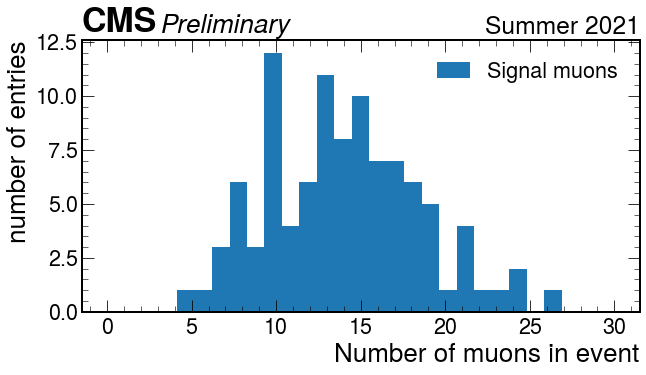

In [9]:
#lets draw hisgorgam of number of muons:
f, ax = plt.subplots(figsize=(10,5))
plt.hist(n_muons, bins=np.linspace(0,30,30),label='Signal muons')
hep.cms.label(llabel="Preliminary", rlabel="Summer 2021", ax=ax)
ax.legend(); 
ax.set(xlabel='Number of muons in event', ylabel='number of entries')
#plt.savefig('Correct/number_muons_signal.png',bbox_inches='tight')

As shown in the example above, there are more than two muons in the process $pp\to p \oplus \mu \mu \oplus p$. Where are other muons coming from? To understand it better, let's look at the muon rapidity (or [pseudorapidity](https://en.wikipedia.org/wiki/Pseudorapidity) as muon mass is negligible compare to the momentum):
`muons.pfcand_eta` is a [awkward.highlevel.Array](https://awkward-array.readthedocs.io/en/latest/_auto/ak.Array.html) array with non regular vector size (each event has different number of muons). To plot all muons together we need to use `ak.layout.Content` to make a single array of all muons, and then call `awkward.to_numpy(array)` to convert the output to [numpy.array](https://numpy.org/doc/stable/reference/generated/numpy.array.html)

[Text(1, 14.0, '$\\eta$ of muons'), Text(46.5, 1, 'number of entries')]

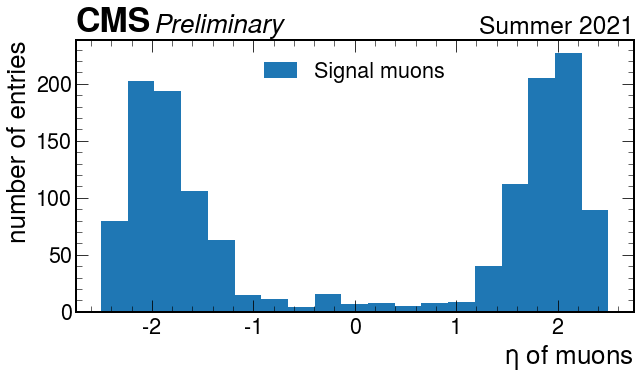

In [10]:
f, ax = plt.subplots(figsize=(10,5))
plt.hist(awkward.to_numpy(muons.pfcand_eta.layout.content), bins=np.linspace(-2.5,2.5,20),label='Signal muons')
hep.cms.label(llabel="Preliminary", rlabel="Summer 2021", ax=ax)
ax.legend(); 
ax.set(xlabel=r'$\eta$ of muons', ylabel='number of entries')
#plt.savefig('Correct/muon_eta.png',bbox_inches='tight')

OK, we see that most of the muons are in the forward region. This is because particles (like pions) pass through more material moving forward (backward) and tend to decay, so more muons are produced.

See for example, expected trigger rate for muons with $p_T>$ 10 GeV at HL-LHC for ATLAS experiment (Fig 2.6 of [CERN-LHCC-2013-006](https://cds.cern.ch/record/1552862)):

<img src="http://cds.cern.ch/record/2641653/files/trigger-rate.png" width=600 height=400 />


### Selecting signal muons

Muons originating from pion decay or other pileup interactions are usually very soft. To select signal muons, we will select two opposite sign leading muons. To do it, we need to loop over all events and construct a new dataframe with the relevant information.

In [117]:
#Note that for muons and protons, you have 2 of each
#if you are interested in the correlation between proton_vz and muon_vz, you can try to use the average value
#of two particles:
protons_vz = np.average([analysis['s_pr1_vz'].values,analysis['s_pr2_vz'].values],axis=0)
muons_vz = np.average([analysis['s_mu1_vz'].values,analysis['s_mu2_vz'].values],axis=0)
muons_tz = np.average([analysis['s_mu1_t'].values,analysis['s_mu2_t'].values],axis=0)


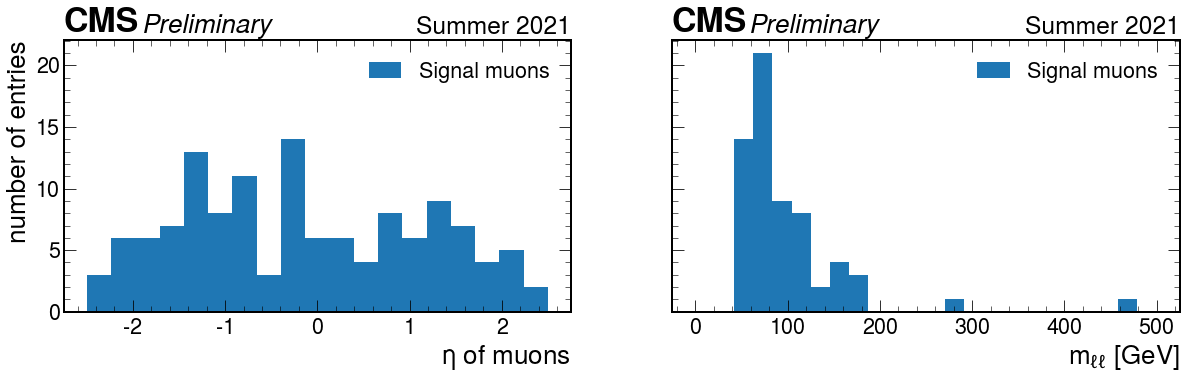

In [118]:
f, ax = plt.subplots(1,2,figsize=(20,5),sharey=True)
ax[0].hist(np.concatenate([analysis['s_mu1_eta'].values,analysis['s_mu2_eta'].values]), bins=np.linspace(-2.5,2.5,20),label='Signal muons')
ax[0].set(xlabel=r'$\eta$ of muons', ylabel='number of entries')

ax[1].hist(analysis['s_mll'].values, bins=np.linspace(0,500,25),label='Signal muons')
ax[1].set(xlabel=r'$m_{\ell\ell}$ [GeV]')

for i in range(2):
    hep.cms.label(llabel="Preliminary", rlabel="Summer 2021", ax=ax[i])
    ax[i].legend()
#plt.savefig('Correct/dimuon_analysis.png',bbox_inches='tight')

Now we will plot the invariant mass of two leptons, and the $\eta$ distribution of signal leptons:

NOTE: the low $m_{\ell\ell}$ entries are from backgound muons, easy to see it using 2D scatter plot between leading muon $p_T$ and invariant mass:

64


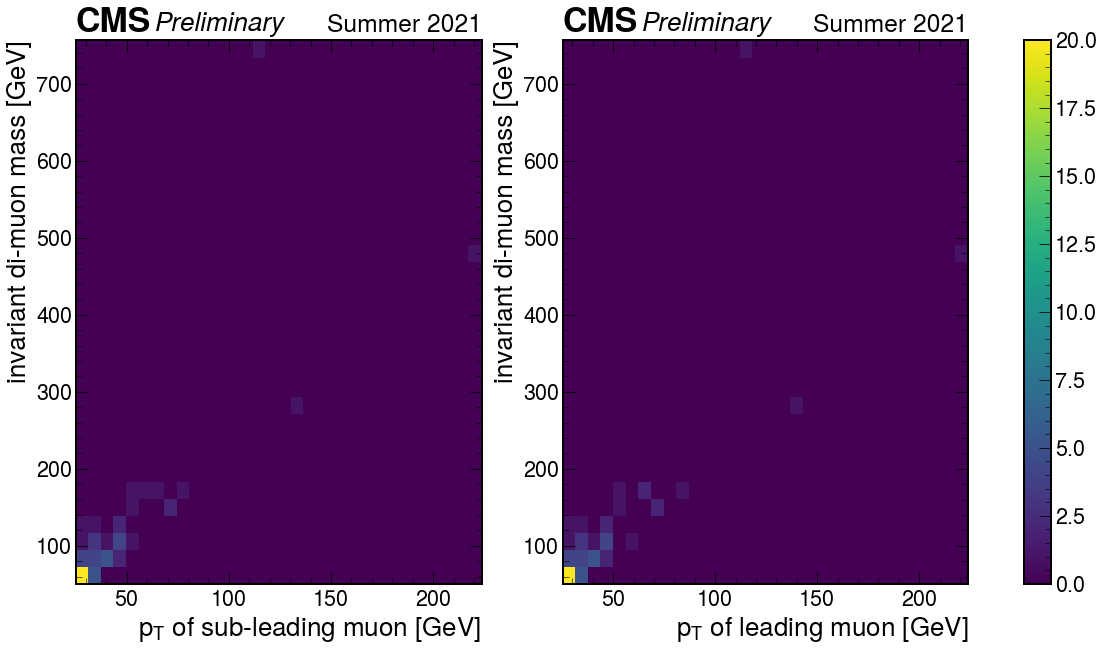

In [119]:

#plot correlation between muon pt and inv mass
fig, axes = plt.subplots(1,2,figsize=(20,10) )
axes[0].hist2d( analysis['s_mu2_pt'].values, analysis['s_mll'].values, bins=(32,32) , cmap='viridis')
axes[0].set(xlabel=r'$p_T$ of sub-leading muon [GeV]', ylabel='invariant di-muon mass [GeV]')
print(len(analysis['s_mu2_pt'].values))
h = axes[1].hist2d( analysis['s_mu1_pt'].values, analysis['s_mll'].values, bins=(32,32) , cmap='viridis')
axes[1].set(xlabel=r'$p_T$ of leading muon [GeV]', ylabel='invariant di-muon mass [GeV]')
fig.colorbar(h[3], ax=axes)
for i in range(2): hep.cms.label(llabel="Preliminary", rlabel="Summer 2021", ax=axes[i])
#plt.savefig('Correct/dimuon_pT_invm_correlation.png')


### Event variables and signal muons

In the next cell, we will plot the correlation between the time measured for each one of the muons and the actual time the collision happens (`genvtx_t0`).

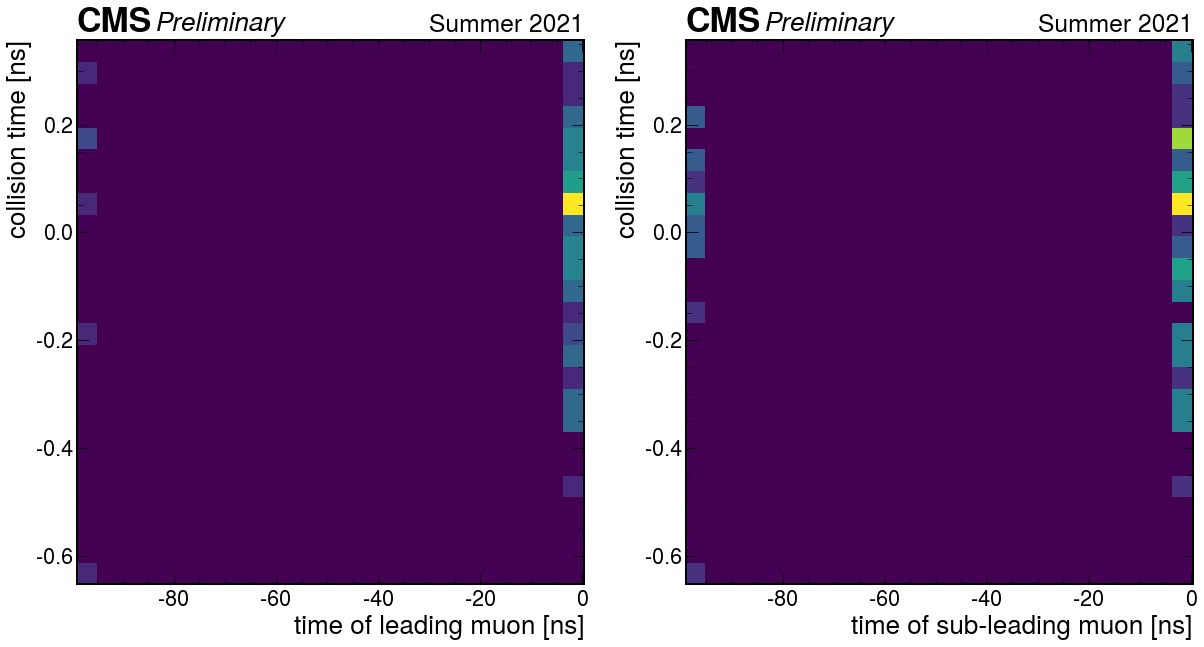

In [14]:
#plot correlation between muon time and event time
fig, axes = plt.subplots(1,2,figsize=(20,10) )
axes[0].hist2d( analysis['s_mu1_t'].values, analysis['s_evt_t0'].values, bins=(25,25) , cmap='viridis')
axes[0].set(xlabel='time of leading muon [ns]', ylabel='collision time [ns]')

axes[1].hist2d( analysis['s_mu2_t'].values, analysis['s_evt_t0'].values, bins=(25,25) , cmap='viridis')
axes[1].set(xlabel='time of sub-leading muon [ns]', ylabel='collision time [ns]')

for i in range(2): hep.cms.label(llabel="Preliminary", rlabel="Summer 2021", ax=axes[i])
#plt.savefig('Correct/dimuon_analysis_time_correlation.png')

We copy-paste the analysis cell here, adding event info to the dataframe:

58


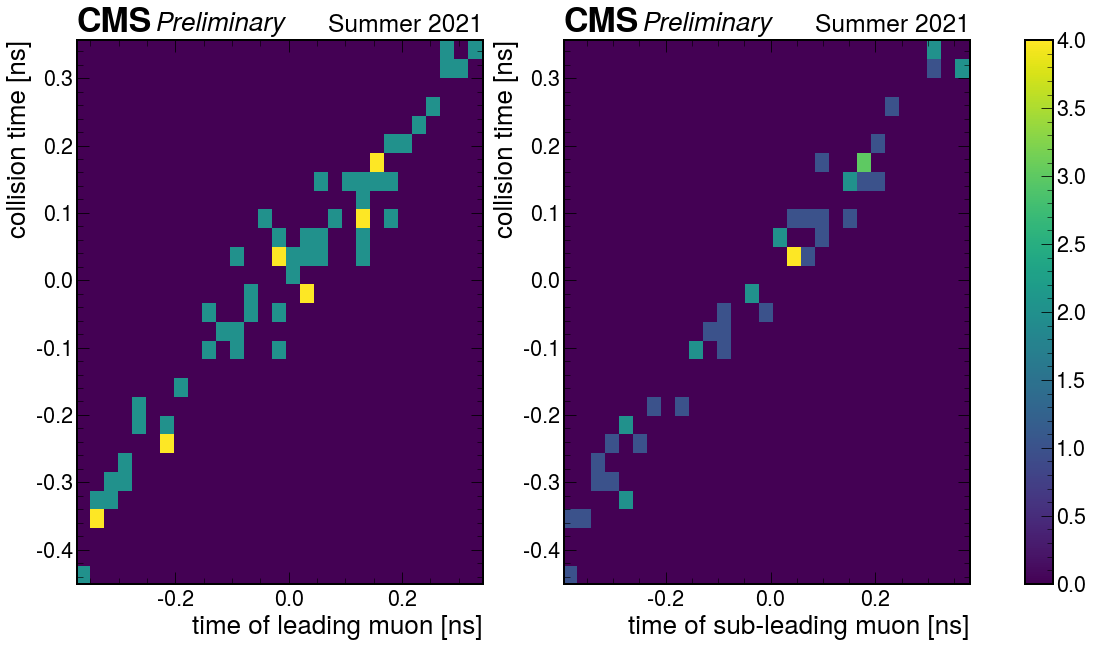

In [43]:
mask_muon1_measured_time = analysis['s_mu1_t']>-80
mask_muon2_measured_time = analysis['s_mu2_t']>-80

#plot correlation between muon time and event time
fig, axes = plt.subplots(1,2,figsize=(20,10) )
masked_analysis=analysis[mask_muon1_measured_time]
print(len(masked_analysis['s_mu2_t'].values))
axes[0].hist2d( masked_analysis['s_mu1_t'].values, masked_analysis['s_evt_t0'].values, bins=(29,29) , cmap='viridis')
axes[0].set(xlabel='time of leading muon [ns]', ylabel='collision time [ns]')
masked_analysis=analysis[mask_muon2_measured_time]
h = axes[1].hist2d( masked_analysis['s_mu2_t'].values, masked_analysis['s_evt_t0'].values, bins=(29,29) , cmap='viridis')
axes[1].set(xlabel='time of sub-leading muon [ns]', ylabel='collision time [ns]')
fig.colorbar(h[3], ax=axes)
for i in range(2): hep.cms.label(llabel="Preliminary", rlabel="Summer 2021", ax=axes[i])

#plt.savefig('Correct/dimuon_analysis_time_correlation_masked.png')

NOTE: some muons don't have reconstructed time, therefore their `t=-99` When working with pandas dataframe it useful to **mask** events (filter) before plotting:

45


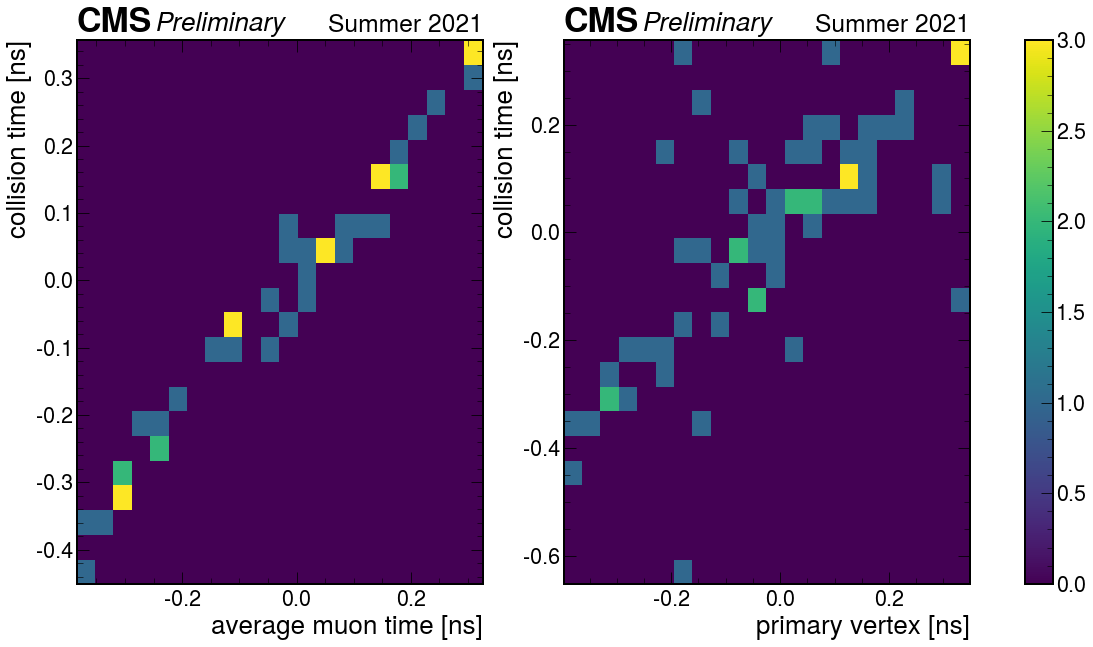

In [49]:

mask_muon_measured_time = (analysis['s_mu1_t']>-80) & (analysis['s_mu2_t']>-80)
masked_analysis=analysis[mask_muon_measured_time]

muons_tz_m = np.average([masked_analysis['s_mu1_t'].values,masked_analysis['s_mu2_t'].values],axis=0)
print(len(muons_tz_m))
fig, axes = plt.subplots(1,2,figsize=(20,10) )
axes[0].hist2d( muons_tz_m, masked_analysis['s_evt_t0'].values, bins=(22,22) , cmap='viridis')
axes[0].set(xlabel='average muon time [ns]', ylabel='collision time [ns]')

genvtx = analysis['s_evt_t0']
vtx4Dt = analysis['s_pr_vtx_t']

h=axes[1].hist2d(vtx4Dt, genvtx, bins=(22,22) , cmap='viridis')
axes[1].set(xlabel=r'primary vertex [ns]', ylabel='collision time [ns]')

fig.colorbar(h[3], ax=axes)
for i in range(2): hep.cms.label(llabel="Preliminary", rlabel="Summer 2021", ax=axes[i])

#plt.savefig('Correct/coll_mu_coll_prim_corr.png')#implement mask

### MIP Timining Detector (MTD) resolution

In the following cell we will plot the MTD timing resolution as obtained from the simulation. Resoluiton is measured in percent (%) and defined by the standard variation of the difference between recontructed and true values:
$ \sigma^2 = \frac{1}{N-1}\Sigma \left(t_{rec} - t_{true}\right)^2 $

(-0.6, 0.6)

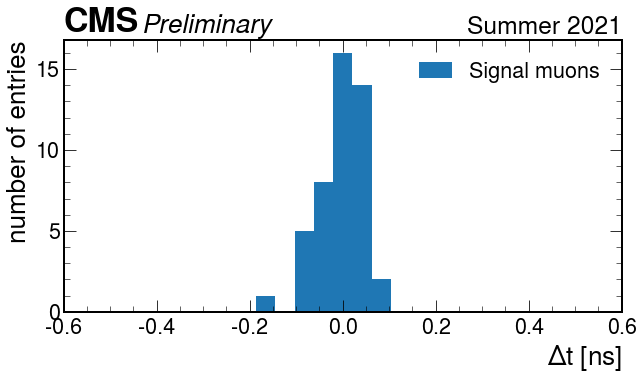

In [50]:

data = analysis['s_mu1_t'] - analysis['s_mu2_t']

bins = np.linspace(-0.6,0.6,30)
#print(val)
f, ax = plt.subplots(figsize=(10,5))
plt.hist(data, bins,label='Signal muons')
hep.cms.label(llabel="Preliminary", rlabel="Summer 2021", ax=ax)
ax.legend(); 
ax.set(xlabel=r'$\Delta$t [ns]', ylabel='number of entries')
plt.xlim(-0.6,0.6)
#plt.savefig('Correct/mu1_mu2_difft.png',bbox_inches='tight')

In [12]:
mask_muon1_measured_time = analysis['s_mu1_t']>-80
mask_muon2_measured_time = analysis['s_mu2_t']>-80


In [13]:
recontsructed_time_resolution1 = analysis[mask_muon1_measured_time]['s_mu1_t'].values - analysis[mask_muon1_measured_time]['s_evt_t0'].values
recontsructed_time_resolution2 = analysis[mask_muon2_measured_time]['s_mu2_t'].values - analysis[mask_muon2_measured_time]['s_evt_t0'].values
recontsructed_time_resolution = np.concatenate([recontsructed_time_resolution1,recontsructed_time_resolution2]) #add two arrays together

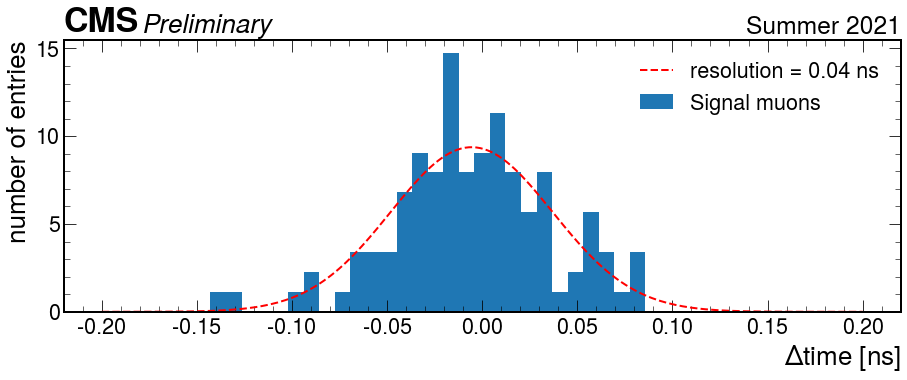

In [53]:
f, ax = plt.subplots(figsize=(15,5))
ax.hist(recontsructed_time_resolution, bins=np.linspace(-0.2,0.2,50),density=True,label='Signal muons')
ax.set(xlabel=r'$(muon_t - evt_t)$ [ns]', ylabel='number of entries')

#fit to gaussian (to avoid bias from outliers restrict the fitted area):
(mu, sigma) = stats.norm.fit(recontsructed_time_resolution[(recontsructed_time_resolution<0.2) & (recontsructed_time_resolution>-0.2)])
x=np.linspace(-0.2,0.2,200)
y=stats.norm.pdf(x, mu, sigma)
ax.plot(x, y, 'r--', linewidth=2,label='resolution = %2.2f ns'%sigma)

hep.cms.label(llabel="Preliminary", rlabel="Summer 2021", ax=ax)
ax.legend()
plt.savefig('Correct/MTD_resolution_evt.png',bbox_inches='tight')

In [14]:
recontsructed_time_resolution1 = analysis[mask_muon1_measured_time]['s_mu1_t'].values - analysis[mask_muon1_measured_time]['s_pr_vtx_t'].values
recontsructed_time_resolution2 = analysis[mask_muon2_measured_time]['s_mu2_t'].values - analysis[mask_muon2_measured_time]['s_pr_vtx_t'].values
recontsructed_time_resolution = np.concatenate([recontsructed_time_resolution1,recontsructed_time_resolution2]) #add two arrays together

In [1]:
f, ax = plt.subplots(figsize=(15,5))
ax.hist(recontsructed_time_resolution, bins=np.linspace(-0.2,0.2,50),density=True,label='Signal muons')
ax.set(xlabel=r'$\Delta (muon_t - primary_t)$ [ns]', ylabel='number of entries')

#fit to gaussian (to avoid bias from outliers restrict the fitted area):
(mu, sigma) = stats.norm.fit(recontsructed_time_resolution[(recontsructed_time_resolution<0.2) & (recontsructed_time_resolution>-0.2)])
x=np.linspace(-0.2,0.2,200)
y=stats.norm.pdf(x, mu, sigma)
ax.plot(x, y, 'r--', linewidth=2,label='resolution = %2.2f ns'%sigma)

hep.cms.label(llabel="Preliminary", rlabel="Summer 2021", ax=ax)
ax.legend()
plt.savefig('Correct/MTD_resolution_4D.png',bbox_inches='tight')

NameError: name 'plt' is not defined

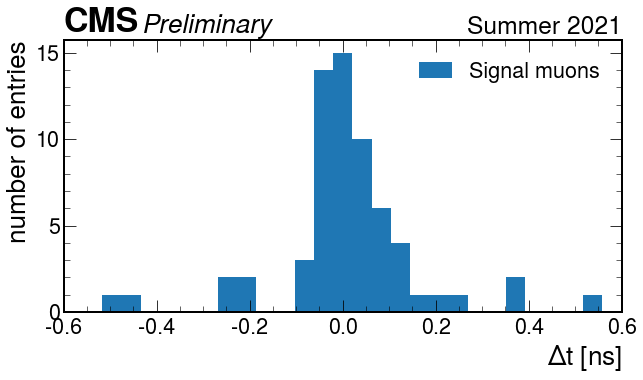

In [57]:
val = analysis['s_evt_t0'] - analysis['s_pr_vtx_t']
bins = np.linspace(-0.6,0.6,30)
#print(val)
f, ax = plt.subplots(figsize=(10,5))
plt.hist(val, bins,label='Signal muons')
hep.cms.label(llabel="Preliminary", rlabel="Summer 2021", ax=ax)
ax.legend(); 
ax.set(xlabel=r'$\Delta$t [ns]', ylabel='number of entries')
plt.xlim(-0.6,0.6)
plt.savefig('Correct/evt_minus_4Dt.png',bbox_inches='tight')

[Text(1, 14.0, '$\\Delta$t [ns]'), Text(58.5, 1, 'number of entries')]

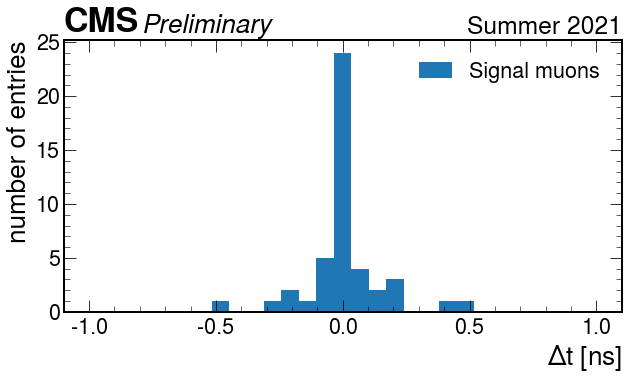

In [58]:

data = muons_tz - analysis['s_pr_vtx_t']

bins = np.linspace(-1,1,30)
#print(val)
f, ax = plt.subplots(figsize=(10,5))
plt.hist(data, bins,label='Signal muons')
hep.cms.label(llabel="Preliminary", rlabel="Summer 2021", ax=ax)
ax.legend(); 
ax.set(xlabel=r'$\Delta$t [ns]', ylabel='number of entries')
#plt.xlim(-0.2,0.2)
#plt.savefig('Correct/avmu_4D_difft.png',bbox_inches='tight')

64
64


[Text(1, 14.0, '$\\Delta$z [cm]'), Text(58.5, 1, 'number of entries')]

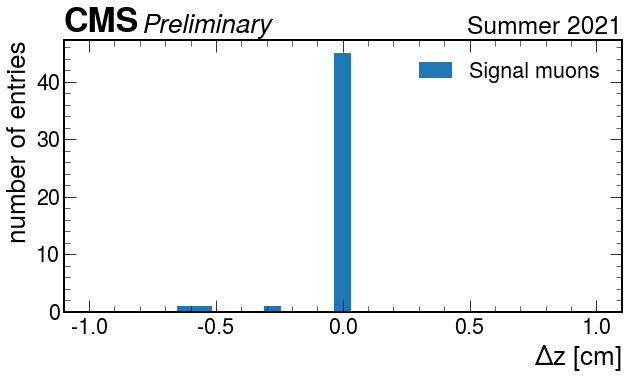

In [59]:

D4 = analysis['s_pr_vtx_z']
print(len(muons_vz))
print(len(D4))
data = muons_vz - D4

bins = np.linspace(-1,1,30)
#print(val)
f, ax = plt.subplots(figsize=(10,5))
plt.hist(data, bins,label='Signal muons')
hep.cms.label(llabel="Preliminary", rlabel="Summer 2021", ax=ax)
ax.legend(); 
ax.set(xlabel=r'$\Delta$z [cm]', ylabel='number of entries')
#plt.xlim(-0.2,0.2)
#plt.savefig('Correct/mu_4D_diffz.png',bbox_inches='tight')

64


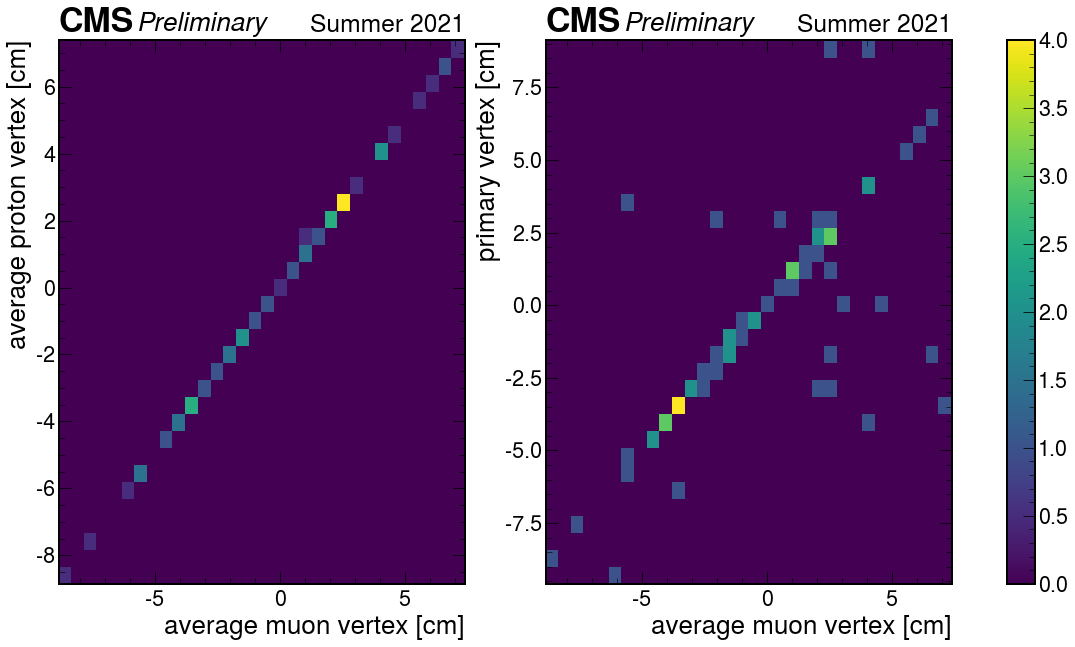

In [62]:
#protons = tree.arrays(['pfcand_pt','pfcand_eta','pfcand_phi','pfcand_mass','pfcand_t','pfcand_vz'],'abs(pfcand_pid)==13')
import matplotlib as mpl

#plot correlation between muon time and event time
fig, axes = plt.subplots(1,2,figsize=(20,10) )
masked_analysis=analysis[mask_muon1_measured_time]
print(len(muons_vz))
axes[0].hist2d(muons_vz, protons_vz, bins=(32,32) , cmap='viridis')
axes[0].set(xlabel=r'average muon vertex [cm]', ylabel='average proton vertex [cm]')


h=axes[1].hist2d(muons_vz, analysis['s_pr_vtx_z'], bins=(32,32) , cmap='viridis')
axes[1].set(xlabel=r'average muon vertex [cm]', ylabel='primary vertex [cm]')

fig.colorbar(h[3], ax=axes)
for i in range(2): hep.cms.label(llabel="Preliminary", rlabel="Summer 2021", ax=axes[i])

plt.savefig('Correct/vz_avg_mu_prot_prim_corr.png')#implement mask

In [63]:

mask_muon_measured_time = (analysis['s_mu1_t']>-80) & (analysis['s_mu2_t']>-80)
masked_analysis=analysis[mask_muon_measured_time]

muons_tz_m = np.average([masked_analysis['s_mu1_t'].values,masked_analysis['s_mu2_t'].values],axis=0)


64
64
64


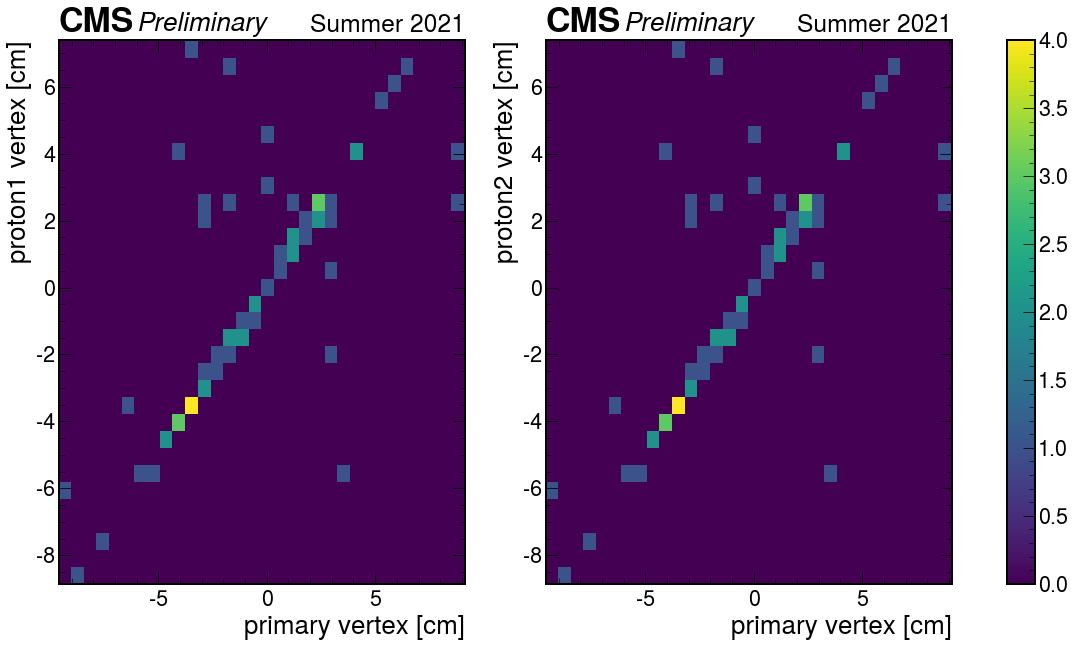

In [66]:
import matplotlib as mpl
# If you plot the correlation between vtx4D_t[0]  and genvtx_t0 OR 

#plot correlation between muon time and event time
fig, axes = plt.subplots(1,2,figsize=(20,10) )
#genvtx = tree['genvtx_t0'].array(library="pd")
genvtx = analysis['s_evt_t0']
vtx4Dt = analysis['s_pr_vtx_t']
vtx4Dz = analysis['s_pr_vtx_z']
print(len(vtx4Dt))
print(len(genvtx))
print(len(vtx4Dz))


axes[0].hist2d(vtx4Dz, analysis['s_pr1_vz'], bins=(32,32) , cmap='viridis')
axes[0].set(xlabel=r'primary vertex [cm]', ylabel='proton1 vertex [cm]')
#axes[0].set_xlim(-1.5,0.4)
#axes[0].set_ylim(-10,8)
h = axes[1].hist2d(vtx4Dz, analysis['s_pr2_vz'], bins=(32,32) , cmap='viridis')
axes[1].set(xlabel=r'primary vertex [cm]', ylabel='proton2 vertex [cm]')
fig.colorbar(h[3], ax=axes)
#axes[1].set_xlim(-10,9)
#axes[1].set_ylim(-10,8)
for i in range(2): hep.cms.label(llabel="Preliminary", rlabel="Summer 2021", ax=axes[i])

plt.savefig('Correct/corr_vtx4D0_p1_p2.png')

64
64
64


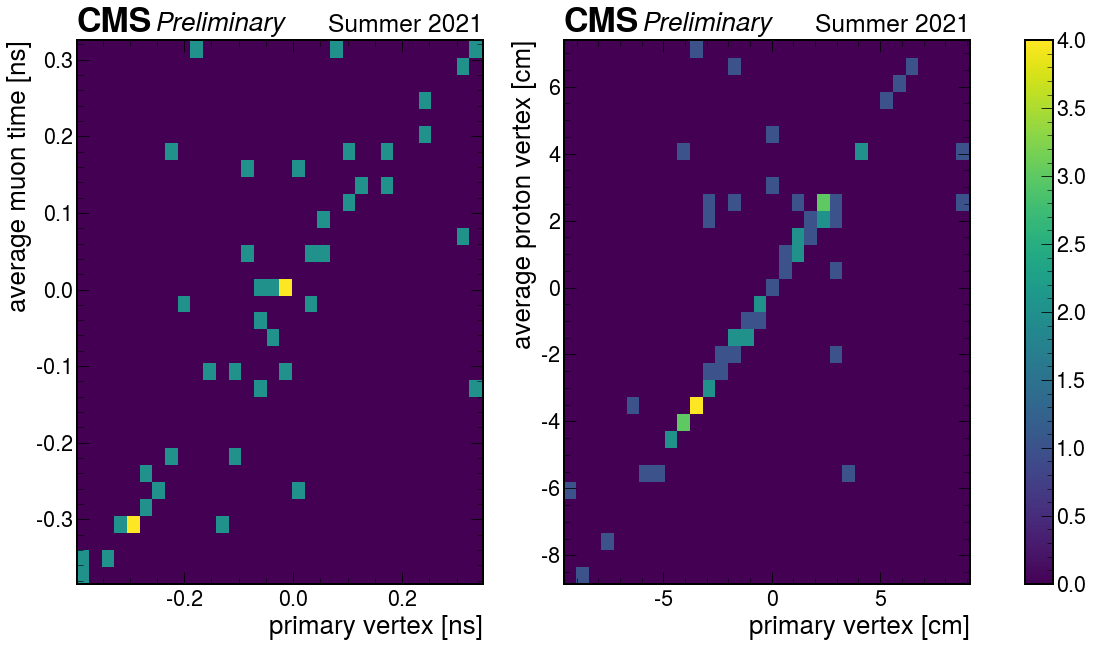

In [68]:
#plot correlation between muon time and event time
fig, axes = plt.subplots(1,2,figsize=(20,10) )
#genvtx = tree['genvtx_t0'].array(library="pd")
genvtx = analysis['s_evt_t0']
vtx4Dt = analysis['s_pr_vtx_t']
vtx4Dz = analysis['s_pr_vtx_z']
print(len(vtx4Dt))
print(len(genvtx))
print(len(vtx4Dz))


axes[0].hist2d(masked_analysis['s_pr_vtx_t'].values, muons_tz_m, bins=(32,32) , cmap='viridis')#mask
axes[0].set(xlabel=r'primary vertex [ns]', ylabel='average muon time [ns]')
#axes[0].set_xlim(-1.5,0.4)
#axes[0].set_ylim(-10,8)
h = axes[1].hist2d(vtx4Dz, protons_vz, bins=(32,32) , cmap='viridis')
axes[1].set(xlabel=r'primary vertex [cm]', ylabel='average proton vertex [cm]')
fig.colorbar(h[3], ax=axes)
#axes[1].set_xlim(-10,9)
#axes[1].set_ylim(-10,8)
for i in range(2): hep.cms.label(llabel="Preliminary", rlabel="Summer 2021", ax=axes[i])

#plt.savefig('Correct/corr_vtx4D0_genvtx.png')

64


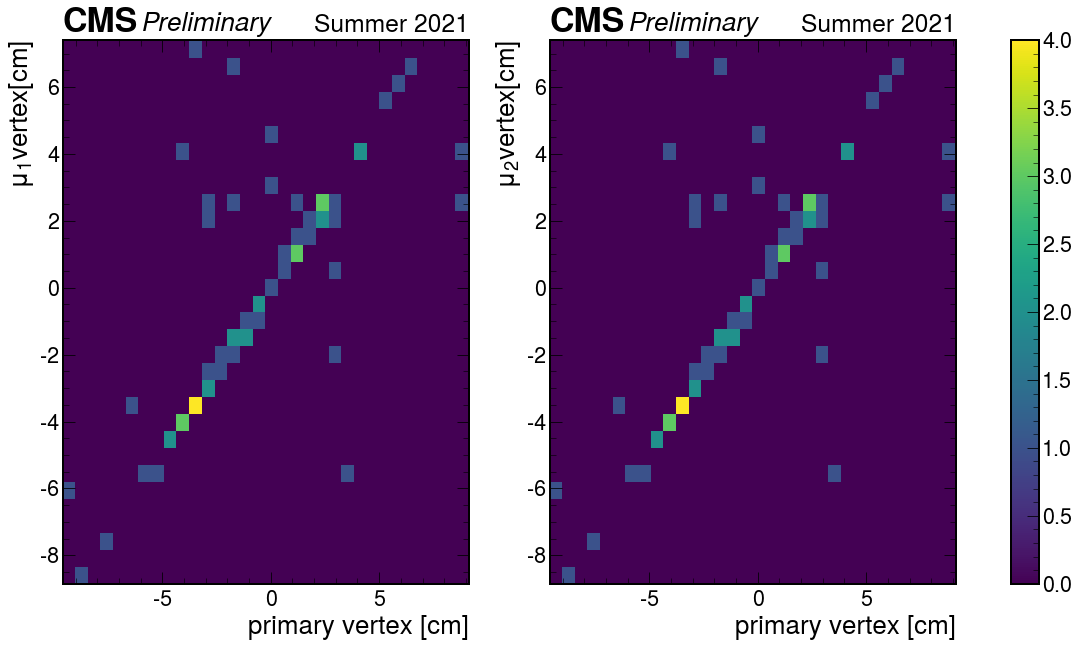

In [70]:
 #vtx4D_t[0]  and mu[1,2]_t OR  vtx4D_z[0]  and mu[1,2]_vz

import matplotlib as mpl
#(muons_anal['mu2_vz'].values, muons_anal['mu1_vz'].values)

fig, axes = plt.subplots(1,2,figsize=(20,10) )
genvtx = analysis['s_evt_t0']
vtx4Dt = analysis['s_pr_vtx_t']
vtx4Dz = analysis['s_pr_vtx_z']
print(len(vtx4Dz))    
axes[0].hist2d(vtx4Dz, analysis['s_mu1_vz'].values, bins=(32,32) , cmap='viridis')
axes[0].set(xlabel=r'primary vertex [cm]', ylabel=r'$\mu_{1} vertex [cm] $')
#axes[0].set_ylim(-9,7.5)

h = axes[1].hist2d(vtx4Dz, analysis['s_mu2_vz'].values, bins=(32,32) , cmap='viridis')
axes[1].set(xlabel=r'primary vertex [cm]', ylabel=r'$\mu_{2} vertex [cm] $')
#axes[1].set_ylim(-9,9)
fig.colorbar(h[3], ax=axes)

for i in range(2): hep.cms.label(llabel="Preliminary", rlabel="Summer 2021", ax=axes[i])

#plt.savefig('Correct/corr_vtx4Dz0_mu1mu2.png')

64
45


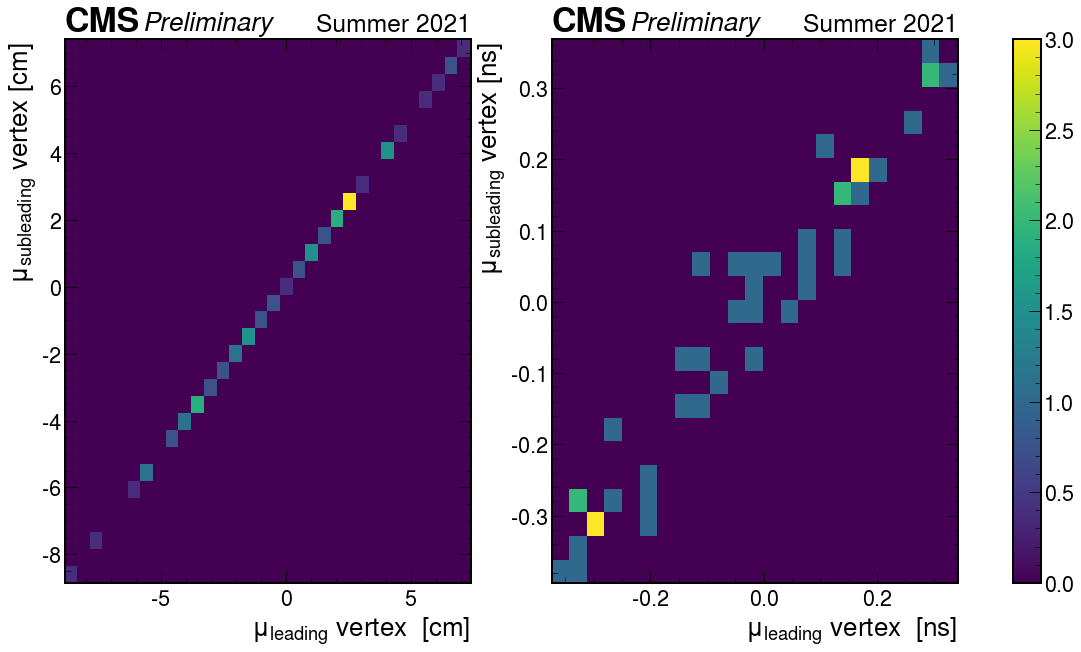

In [73]:
import matplotlib as mpl
mask_muon1_measured_time = analysis['s_mu1_t']>-20
mask_muon2_measured_time = analysis['s_mu1_t']>-20
masked_analysis1=analysis[mask_muon1_measured_time]
masked_analysis2=analysis[mask_muon2_measured_time]
fig, axes = plt.subplots(1,2,figsize=(20,10) )
print(len(analysis['s_mu1_vz'].values))
axes[0].hist2d(analysis['s_mu1_vz'].values , analysis['s_mu2_vz'].values, bins=(32,32) , cmap='viridis')
axes[0].set(xlabel=r'$\mu_{leading}$ vertex  [cm]', ylabel=r'$\mu_{subleading}$ vertex [cm] ')
#axes[0].set_ylim(-9,7.5)
print(len(masked_analysis['s_mu1_t'].values))
h = axes[1].hist2d(masked_analysis['s_mu1_t'].values , masked_analysis['s_mu2_t'].values, bins=(23,23) , cmap='viridis')#hmmm
axes[1].set(xlabel=r'$\mu_{leading}$ vertex  [ns]', ylabel=r'$\mu_{subleading}$ vertex [ns] ')
#axes[1].set_ylim(-9,9)
fig.colorbar(h[3], ax=axes)

for i in range(2): hep.cms.label(llabel="Preliminary", rlabel="Summer 2021", ax=axes[i])

plt.savefig('Correct/corr_mu1mu2_t_z.png')

[Text(1, 14.0, '$\\Delta$t [ns]'), Text(70.5, 1, 'number of entries')]

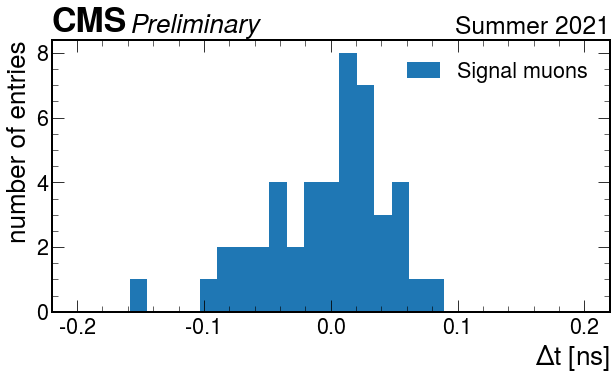

In [74]:
#mask_1 = analysis['mu1_t']>-80
#mask_2 = >-80

data = analysis['s_mu1_t'] -analysis['s_mu2_t']

bins = np.linspace(-0.2,0.2,30)
#print(val)
f, ax = plt.subplots(figsize=(10,5))
plt.hist(data, bins,label='Signal muons')
hep.cms.label(llabel="Preliminary", rlabel="Summer 2021", ax=ax)
ax.legend(); 
ax.set(xlabel=r'$\Delta$t [ns]', ylabel='number of entries')
#plt.xlim(-0.2,0.2)
#plt.savefig('Correct/mu1_mu2_difft.png',bbox_inches='tight')

58
50


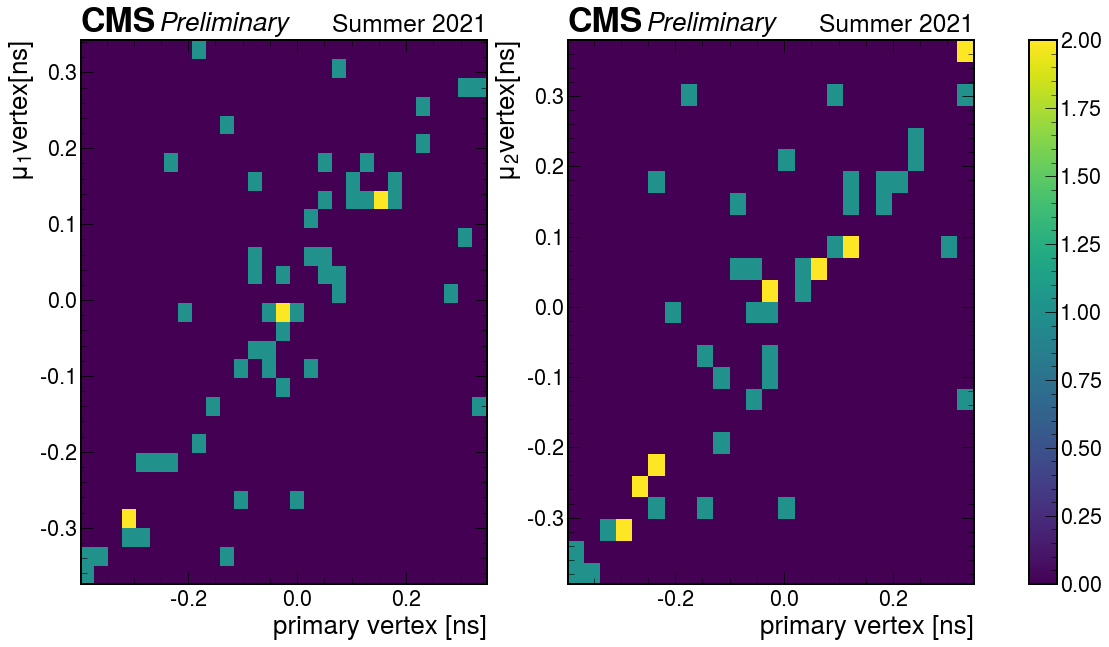

In [75]:
import matplotlib as mpl
mask_mu1 = analysis['s_mu1_t']>-80
mask_mu2 = analysis['s_mu2_t']>-80

fig, axes = plt.subplots(1,2,figsize=(20,10) )
vtx4Dt = analysis['s_pr_vtx_t']
print(len(analysis[mask_mu1]['s_pr_vtx_t'].values))
axes[0].hist2d(analysis[mask_mu1]['s_pr_vtx_t'].values, analysis[mask_mu1]['s_mu1_t'].values, bins=(29,29),cmap='viridis')
axes[0].set(xlabel=r'primary vertex [ns]', ylabel=r'$\mu_{1} vertex [ns] $')
print(len(analysis[mask_mu2]['s_pr_vtx_t'].values))
h = axes[1].hist2d(analysis[mask_mu2]['s_pr_vtx_t'].values, analysis[mask_mu2]['s_mu2_t'].values, bins=(25,25),cmap='viridis')
axes[1].set(xlabel=r'primary vertex [ns]', ylabel=r'$\mu_{2} vertex [ns] $')
fig.colorbar(h[3], ax=axes)

for i in range(2): hep.cms.label(llabel="Preliminary", rlabel="Summer 2021", ax=axes[i])
plt.savefig('Correct/corr_vtx4Dt0_mu1mu2.png')

64


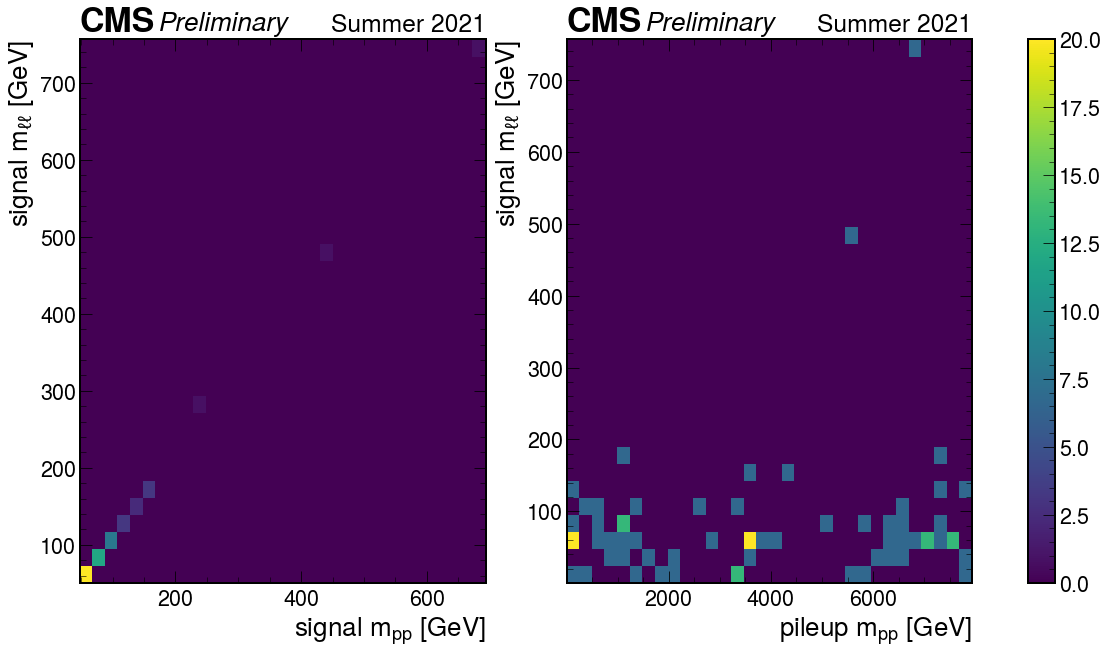

In [120]:
#plot mpp vs mll for pile-up and signal pairs.

fig, axes = plt.subplots(1,2,figsize=(20,10) )
proton = analysis['s_mpp'].values
muon = analysis['s_mll'].values
print(len(analysis['s_mpp'].values))
axes[0].hist2d(analysis['s_mpp'].values, analysis['s_mll'].values, bins=(32,32) , cmap='viridis')
axes[0].set(xlabel=r'signal $m_{pp}$ [GeV]', ylabel=r'signal $m_{\ell \ell}$ [GeV]')
#axes[0].set_ylim(50,500)
#axes[0].set_xlim(50,500)
axes[1].hist2d(analysis['b_mpp'].values, analysis['b_mll'].values, bins=(32,32) , cmap='viridis')
axes[1].set(xlabel=r'pileup $m_{pp}$ [GeV]', ylabel=r'signal $m_{\ell \ell}$ [GeV]')
#axes[1].set_ylim(0,200)
fig.colorbar(h[3], ax=axes)

for i in range(2): hep.cms.label(llabel="Preliminary", rlabel="Summer 2021", ax=axes[i])

plt.savefig('AnalyseW2/corr_mpp_mll.png')

64


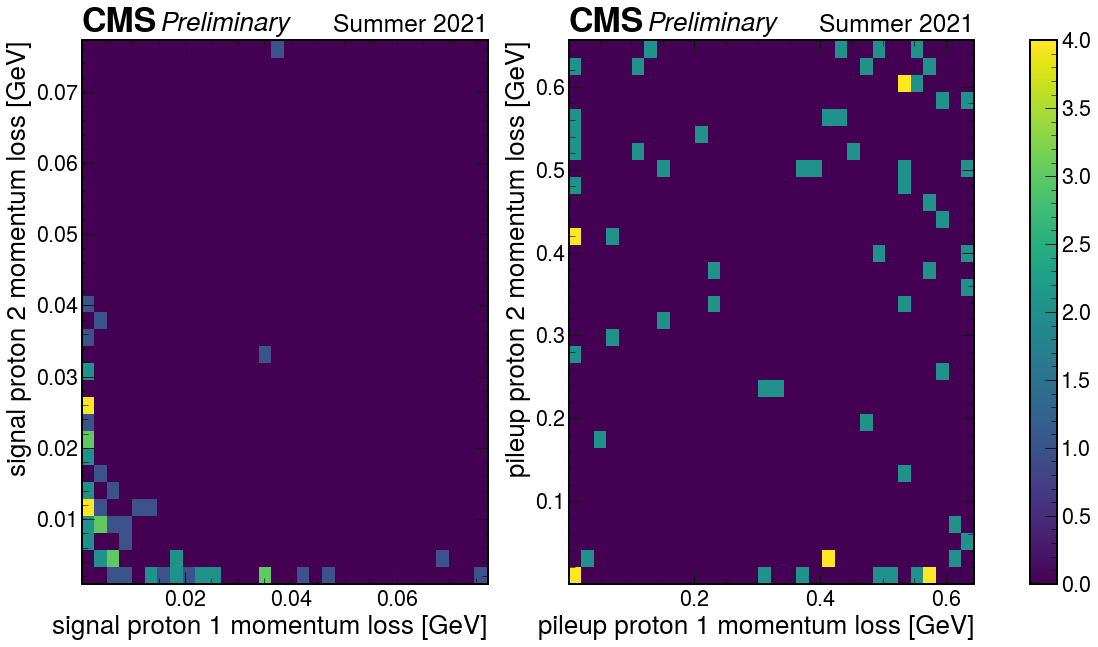

In [114]:
#mask the values

fig, axes = plt.subplots(1,2,figsize=(20,10) )
print(len(analysis['s_pr1_xi'].values))
h = axes[0].hist2d(analysis['s_pr1_xi'].values, analysis['s_pr2_xi'].values, bins=(32,32) , cmap='viridis')
axes[0].set(xlabel=r'signal proton 1 momentum loss [GeV]', ylabel=r'signal proton 2 momentum loss [GeV]')

axes[1].hist2d(analysis['b_pr1_xi'], analysis['b_pr2_xi'], bins=(32,32), cmap='viridis')
axes[1].set(xlabel=r'pileup proton 1 momentum loss [GeV]', ylabel=r'pileup proton 2 momentum loss [GeV]')
#axes[1].set_ylim(-2,0.4)
fig.colorbar(h[3], ax=axes)

for i in range(2): hep.cms.label(llabel="Preliminary", rlabel="Summer 2021", ax=axes[i])

plt.savefig('Week4/xi_corr_random.png')

In [49]:
#Define cut on (mpp-mll)/mpp and see which signal and background rates one can expect with a given cut.
#For 3 you can check out the background sample (DY + pileup protons), apply different cuts, 
#and see the fraction of signal/background events that pass your selection criteria.


[-0.06975752 -0.06866524 -0.08232548 -0.07919887 -0.0605558  -0.05736565
 -0.05279632 -0.07825437 -0.08353117 -0.07407093 -0.06743121 -0.0660808
 -0.06571609 -0.09047572 -0.06897606 -0.06201955 -0.0774407  -0.04966496
 -0.06871342 -0.0760991  -0.06568053 -0.07102212 -0.08362855 -0.07837921
 -0.08404139 -0.0555525  -0.06804691 -0.07134977 -0.06843111 -0.06479663
 -0.08041798 -0.0766213  -0.06863713 -0.06644656 -0.07513856 -0.06043264
 -0.08092375 -0.08268453 -0.06876202 -0.07061356 -0.08114605 -0.0639108
 -0.06981131 -0.10736645 -0.0675176  -0.06880687 -0.06818426 -0.05980316
 -0.08028215 -0.06530358 -0.07528918 -0.07187364 -0.06520431 -0.06717112
 -0.06212464 -0.05788313 -0.07345177 -0.12877342 -0.06562791 -0.06659928
 -0.05027392 -0.06337105 -0.05910557 -0.07058189]


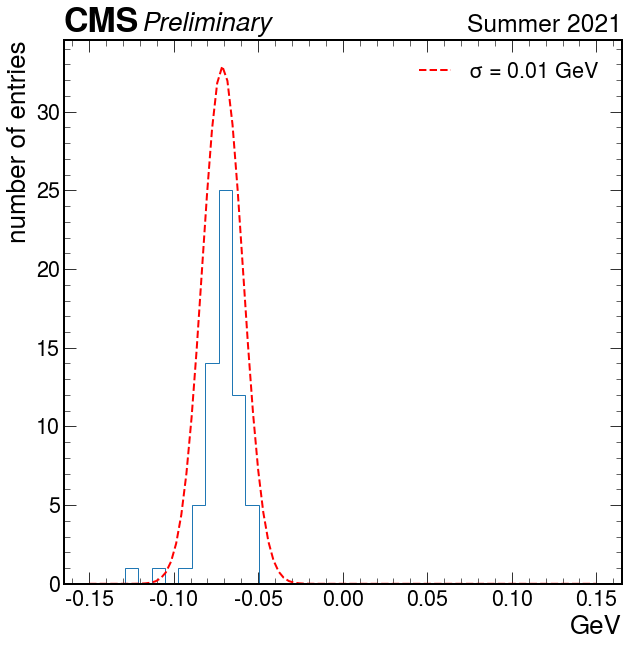

In [36]:
#You can plot mpp/mll-1 distribution, fit a gaussian and define a cut to be within the 2 sigma: |mpp-mll| < 2*sigma*mll
#print(analysis['s_mpp'].values)
#print(analysis['s_mll'].values)
data = (analysis['s_mpp'].values/analysis['s_mll'].values)-1
print(data)
bins = np.linspace(-0.15,0.15,100)
f, ax = plt.subplots()
plt.hist(data, histtype='step')

#fit to gaussian (to avoid bias from outliers restrict the fitted area):  = analysis['s_mpp']-analysis['s_mll'] <
(mu, sigma) = stats.norm.fit(data)
x=bins
y=stats.norm.pdf(x, mu, sigma)
ax.plot(x, y, 'r--', linewidth=2,label='$\sigma$ = %2.2f GeV'%sigma)
#print(2*sigma*analysis['s_mll'])

hep.cms.label(llabel="Preliminary", rlabel="Summer 2021", ax=ax)
ax.set(xlabel='GeV', ylabel='number of entries')

ax.legend()
#plt.savefig('AnalyseW2/fit_mass_ratio.png')

In [51]:
# get background data 